In [26]:
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Dataset
from models import *
from torch import nn
from PIL import Image
import os
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm
import numpy as np
from utilities import *

In [2]:
%matplotlib inline

In [3]:
class CustomImageDataset(Dataset):
    def __init__(self, image_directory, transform=None):
        self.image_directory = image_directory
        self.image_filenames = [f for f in os.listdir(image_directory) if f.endswith(('.png', '.jpg', '.jpeg'))]
        self.transform = transform

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_directory, self.image_filenames[idx])
        image = Image.open(img_path).convert('RGB')  # Convert image to RGB

        if self.transform:
            image = self.transform(image)

        return image  # Ensure you're returning the image, not its filename or path

In [4]:
transform = get_transform_pretrained()

In [5]:
transform

Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)

In [6]:
train_dataset_path = "data/NormalFramesLarge"

In [7]:
train_dataset = CustomImageDataset(train_dataset_path, transform=transform)

In [8]:
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=False)

In [9]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [10]:
device

'cuda'

In [13]:
# defining the model
model = PreTrainedAutoencoder().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [14]:
num_epochs = 15

for epoch in tqdm(range(num_epochs)):
    model.train()
    for batch_images in train_dataloader:
        batch_images = batch_images.to(device)

        # Forward pass
        outputs = model(batch_images)

        outputs = model(batch_images)

        loss = criterion(outputs, batch_images)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

  7%|▋         | 1/15 [11:44<2:44:17, 704.14s/it]

Epoch [1/15], Loss: 0.6004


 13%|█▎        | 2/15 [23:17<2:31:13, 697.99s/it]

Epoch [2/15], Loss: 0.5924


 20%|██        | 3/15 [34:56<2:19:37, 698.14s/it]

Epoch [3/15], Loss: 0.5874


 27%|██▋       | 4/15 [46:26<2:07:25, 695.04s/it]

Epoch [4/15], Loss: 0.5831


 33%|███▎      | 5/15 [57:37<1:54:23, 686.36s/it]

Epoch [5/15], Loss: 0.5802


 40%|████      | 6/15 [1:08:49<1:42:14, 681.62s/it]

Epoch [6/15], Loss: 0.5784


 47%|████▋     | 7/15 [1:20:01<1:30:25, 678.25s/it]

Epoch [7/15], Loss: 0.5766


 53%|█████▎    | 8/15 [1:31:05<1:18:36, 673.74s/it]

Epoch [8/15], Loss: 0.5742


 60%|██████    | 9/15 [1:42:13<1:07:12, 672.15s/it]

Epoch [9/15], Loss: 0.5723


 67%|██████▋   | 10/15 [1:53:20<55:52, 670.55s/it] 

Epoch [10/15], Loss: 0.5733


 73%|███████▎  | 11/15 [2:04:22<44:31, 667.90s/it]

Epoch [11/15], Loss: 0.5720


 80%|████████  | 12/15 [2:15:20<33:14, 664.67s/it]

Epoch [12/15], Loss: 0.5710


 87%|████████▋ | 13/15 [2:26:21<22:07, 663.77s/it]

Epoch [13/15], Loss: 0.5692


 93%|█████████▎| 14/15 [2:37:36<11:07, 667.22s/it]

Epoch [14/15], Loss: 0.5686


100%|██████████| 15/15 [2:48:44<00:00, 674.97s/it]

Epoch [15/15], Loss: 0.5668


In [15]:
# Save the model's state_dict
torch.save(model.state_dict(), 'trained_models/pretrained_model_v1.pth')

In [23]:
def visualize_reconstruction(model,  image_path, transform, device='cuda'):
    """
    Visualizes the original and reconstructed image from the model.

    Args:
    - model (nn.Module): Trained autoencoder model.
    - image_tensor (torch.Tensor): 4D tensor of shape (1, C, H, W).
    - device (str): Device to which model and data should be moved before inference. Default: 'cuda'.

    Returns:
    - reconstruction_error (float): Mean Squared Error between the original and reconstructed image.
    """
    model.eval()  # Set model to evaluation mode

    # Load the image and apply transformations
    image = Image.open(image_path).convert('RGB')
    image_tensor = transform(image).unsqueeze(0)  # Add batch dimension
    model = model.to(device)
    image_tensor = image_tensor.to(device)
    # Get the reconstructed image
    with torch.inference_mode():
        reconstructed_tensor = model(image_tensor)

    # Compute the reconstruction error (MSE)
    mse_loss = torch.nn.functional.mse_loss(image_tensor, reconstructed_tensor)
    reconstruction_error = mse_loss.item()

    # Convert tensors to numpy arrays for visualization
    original_image = image_tensor.squeeze().permute(1, 2, 0).cpu().numpy()
    reconstructed_image = reconstructed_tensor.squeeze().permute(1, 2, 0).cpu().numpy()

    # Assuming images were normalized to [-1, 1], denormalize for visualization
    original_image = (original_image * 0.5) + 0.5
    reconstructed_image = (reconstructed_image * 0.5) + 0.5

    # Visualization using Matplotlib
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(original_image)
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(reconstructed_image)
    plt.title('Reconstructed Image')
    plt.axis('off')

    plt.show()

    return reconstruction_error

In [39]:
def unnormalize(tensor, mean, std):
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor

In [40]:
def visualize_reconstructionv2(model, image_path, transform, device='cuda'):
    model.eval()

    image = Image.open(image_path).convert('RGB')
    image_tensor = transform(image).unsqueeze(0)
    model = model.to(device)
    image_tensor = image_tensor.to(device)

    with torch.inference_mode():
        reconstructed_tensor = model(image_tensor)

    mse_loss = torch.nn.functional.mse_loss(image_tensor, reconstructed_tensor)
    reconstruction_error = mse_loss.item()

    # Step 1: Move tensor to CPU and detach
    original_image = image_tensor[0].cpu().detach()
    reconstructed_image = reconstructed_tensor[0].cpu().detach()

    # Step 2: Unnormalize
    unnormalize(original_image, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    unnormalize(reconstructed_image, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

    # Step 3: Convert to NumPy array for visualization
    original_image = original_image.permute(1, 2, 0).numpy()
    reconstructed_image = reconstructed_image.permute(1, 2, 0).numpy()

    original_image = np.clip(original_image, 0, 1)
    reconstructed_image = np.clip(reconstructed_image, 0, 1)

    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(original_image)
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(reconstructed_image)
    plt.title('Reconstructed Image')
    plt.axis('off')

    plt.show()

    return reconstruction_error

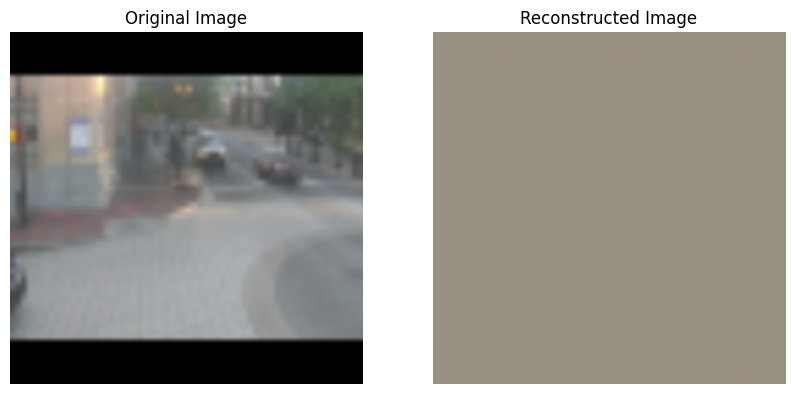

1.7720104455947876

In [41]:
# normal image
normal_image = "data/SmallerDataset/Test/Normal_Videos_912_x264_340.png"
visualize_reconstructionv2(model,  normal_image, transform, device=device)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


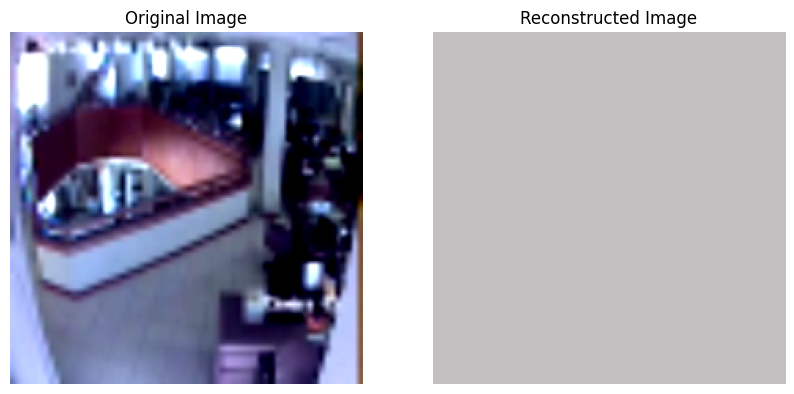

0.8484041094779968

In [42]:
normal_image_2 = "data/SmallerDataset/Test/Normal_Videos_923_x264_10660.png"
visualize_reconstruction(model,  normal_image_2, transform, device=device)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


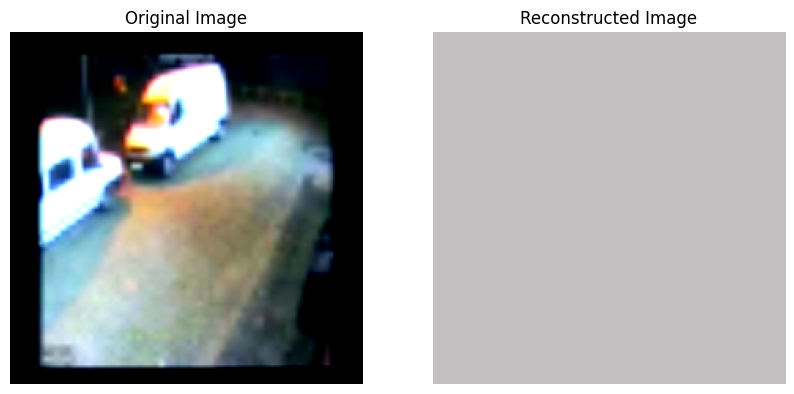

2.1999692916870117

In [43]:
# anomaly images
anomaly_1 = "data/SmallerDataset/AnomalyImages/Arson010_x264_1460.png"
visualize_reconstruction(model,  anomaly_1, transform, device=device)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


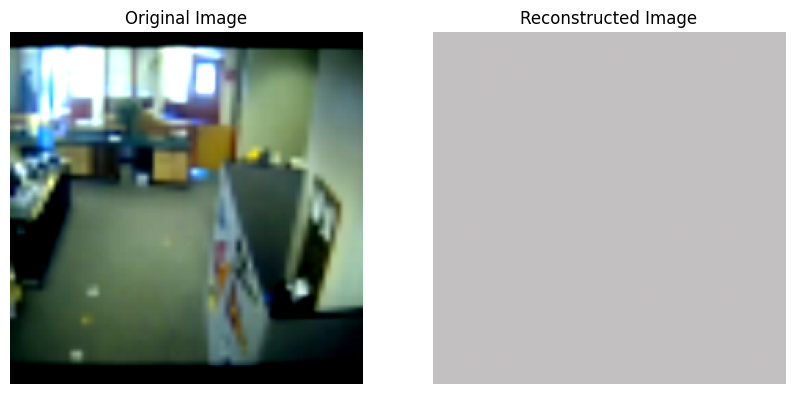

1.335805058479309

In [44]:
anomaly_2 = "data/SmallerDataset/AnomalyImages/Arrest001_x264_480.png"
visualize_reconstruction(model,  anomaly_2, transform, device=device)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


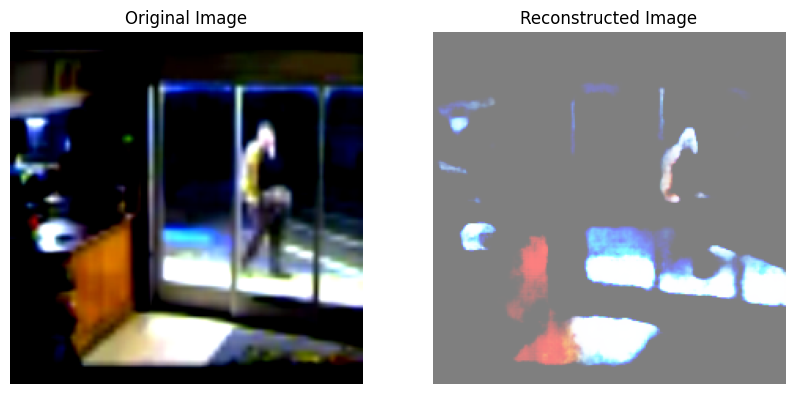

1.3868721723556519

In [21]:
anomaly_3 = "data/SmallerDataset/AnomalyImages/Vandalism017_x264_540.png"
visualize_reconstruction(model, anomaly_3, transform, device=device)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


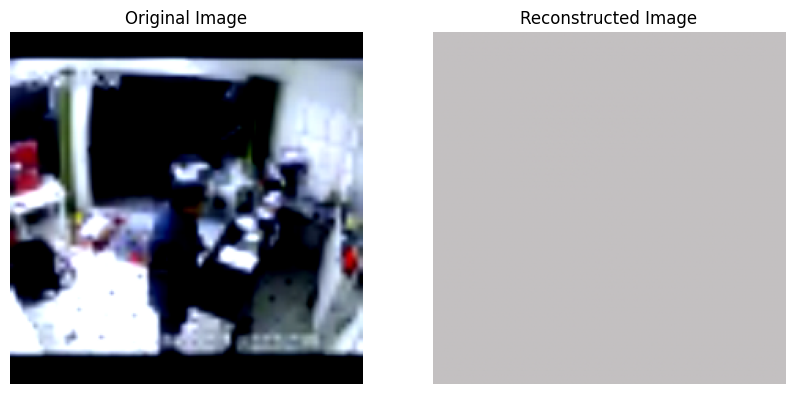

2.412377119064331

In [38]:
anomaly_4 = "data/SmallerDataset/AnomalyImages/Shooting011_x264_3980.png"
visualize_reconstruction(model, anomaly_4, transform, device=device)